Code for testing and development of the function grouped_linear_regression_ols_estimator

This code will test for three things: 

1) It will test that 1-alpha confidence intervals capture the true model coefficients 1-alpha percent of the time

2) It will verify that under the hypothesis that all $\beta$ coefficients are 0 and the distribution of p-values for hypothesis tests of non-zero coefficents are uniformly distributed

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

from janelia_core.stats.regression import grouped_linear_regression_ols_estimator
from janelia_core.stats.regression import grouped_linear_regression_acm_stats

# Make sure confidence intervals are correct

## Parameters go here

In [3]:
# Coefficients of the true model here
coefs = np.arange(10)

# Range of group offsets
grp_offset_range = [-10, 10]

# Range of group noise standard deviations
grp_std_range = [1, 10]

# Number of groups to sample
n_grps = 50

# Define offsets
offsets = np.arange(n_grps)

# Range of the number of samples to generate from each group
n_smps_per_group = [50, 50]

# Number of simulations to perform
n_sims = 100
# Size of 1-alpha confidence interval
alpha = .05

In [4]:
def gen_data(coefs, offsets, n_grps, n_smps_per_group, grp_offset_range, grp_std_range):

    n_coefs = len(coefs)

    grp_offsets = np.zeros(n_grps)
    grp_stds = np.zeros(n_grps)
    x_grp = [None]*n_grps
    y_grp = [None]*n_grps
    i_grp = [None]*n_grps

    for g_i in range(n_grps):
        n_grp_smps = np.random.randint(n_smps_per_group[0], n_smps_per_group[1] + 1)
    
        grp_offset = offsets[g_i]
        grp_offsets[g_i] = grp_offset
    
        grp_std = (np.random.rand(1)*(grp_std_range[1] - grp_std_range[0]) + 
                   grp_std_range[0])
        grp_stds[g_i] = grp_std
    
        coef_x = np.random.randn(n_grp_smps, n_coefs)
        #coef_x = coef_x > 0
        dummy_x = np.zeros([n_grp_smps, n_grps]) # Add dummy variables to x
        dummy_x[:, g_i] = 1
        
        
        y_grp[g_i] = (np.matmul(coef_x, coefs) + grp_std*np.random.randn(n_grp_smps) +
                      grp_offset)
        x_grp[g_i] = np.concatenate([coef_x, dummy_x], axis=1)
        i_grp[g_i] = np.ones(n_grp_smps)*g_i
    
    x = np.concatenate(x_grp)
    y = np.concatenate(y_grp)
    grps = np.concatenate(i_grp)
    
    return [x, y, grps]

## Check accuracy of confidence intervals

In [5]:
n_coefs = len(coefs)
beta_captured = np.zeros([n_sims, len(coefs)])
offsets_captured = np.zeros([n_sims, n_grps])

for s_i in range(n_sims):
    x, y, g = gen_data(coefs, offsets, n_grps, n_smps_per_group, grp_offset_range, grp_std_range)
    
    beta, acm, n_g = grouped_linear_regression_ols_estimator(y=y,x=x,g=g)
    stats = grouped_linear_regression_acm_stats(beta,acm, n_g, alpha)
    
    # See if coefficients are in the confidence interval
    beta_captured[s_i, :] = np.logical_and(stats['c_ints'][0,0:n_coefs] <= coefs, 
                                           coefs <= stats['c_ints'][1,0:n_coefs])
    
    offsets_captured[s_i, :] = np.logical_and(stats['c_ints'][0,n_coefs:] <= offsets, 
                                           offsets <= stats['c_ints'][1,n_coefs:])
    
    if s_i % 10 == 0:
        print('Done with simulation ' + str(s_i) + '.')

Done with simulation 0.
Done with simulation 10.
Done with simulation 20.
Done with simulation 30.
Done with simulation 40.
Done with simulation 50.
Done with simulation 60.
Done with simulation 70.
Done with simulation 80.
Done with simulation 90.


In [6]:
p_beta_captured = np.mean(beta_captured, axis=0)
print('Percent Beta captured: ' + str(p_beta_captured))

Percent Beta captured: [0.94 0.96 0.98 0.94 0.96 0.99 0.95 0.94 0.99 0.94]


# Make sure that under the null hypothesis distributions of p-values are uniformly distributed

## Parameters go here

In [7]:
# Number of coefficents in the model
n_coefs = 10

# Range of group offsets
grp_offset_range = [-10, 10]

# Range of group noise standard deviations
grp_std_range = [1, 1]

# Number of groups to sample
n_grps = 50

# Range of the number of samples to generate from each group
n_smps_per_group = [5, 10] # May need to increase # smps per group so
                           # p-value are not biased upwards

# Number of simulations to perform
n_sims = 1000
# Size of 1-alpha confidence interval
alpha = .05

In [8]:
p_vls = np.zeros([n_sims, n_coefs])

for s_i in range(n_sims):
    x, y, g  = gen_data(np.zeros(n_coefs), np.zeros(n_grps), n_grps, n_smps_per_group, grp_offset_range, grp_std_range)
    
    beta, acm, n_g = grouped_linear_regression_ols_estimator(y=y,x=x,g=g)
    stats = grouped_linear_regression_acm_stats(beta,acm,n_g, alpha)
    
    p_vls[s_i, :] = stats['non_zero_p'][0:n_coefs]
    
    if s_i % 100 == 0:
        print('Done with simulation ' + str(s_i) + '.')

Done with simulation 0.
Done with simulation 100.
Done with simulation 200.
Done with simulation 300.
Done with simulation 400.
Done with simulation 500.
Done with simulation 600.
Done with simulation 700.
Done with simulation 800.
Done with simulation 900.


## Visualize distribution of p-values

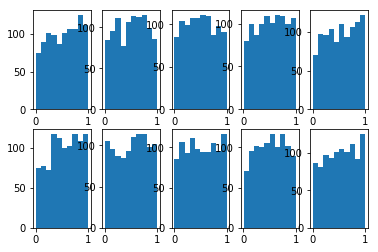

In [9]:
plt.figure()
for c_i in range(n_coefs):
    plt.subplot(2, 5, c_i+1)
    plt.hist(p_vls[:, c_i])

## Make sure offsets are learned correctly

In [10]:
# Coefficients of the true model here
coefs = np.arange(10)

# Range of group offsets
grp_offset_range = [-10, 10]

# Range of group noise standard deviations
grp_std_range = [1, 1]

# Number of groups to sample
n_grps = 50

# Offsets of the true model
offsets = np.arange(n_grps)

# Range of the number of samples to generate from each group
n_smps_per_group = [100, 100]

In [11]:
x, y, g = gen_data(coefs, offsets, n_grps, n_smps_per_group, grp_offset_range, grp_std_range)

In [12]:
beta, acm, n_g = grouped_linear_regression_ols_estimator(y=y,x=x,g=g)
est_offsets = beta[n_coefs:]

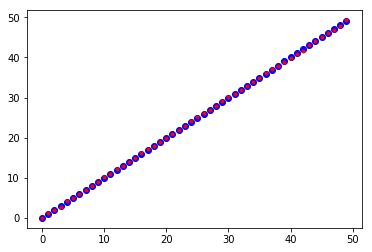

In [13]:
plt.figure()
plt.plot(offsets, 'bo')
plt.plot(est_offsets, 'r.')